## 2. TCGA

TCGA (The Cancer Genome Atlas) es un proyecto colaborativo dirigido por el Instituto Nacional del Cáncer
(NCI) y el Instituto Nacional de Investigación del Genoma Humano (NHGRI) en los Estados Unidos. Su objetivo
principal es caracterizar exhaustivamente las alteraciones genómicas en el cáncer mediante el análisis de
grandes conjuntos de datos de pacientes con cáncer. Se pretende crear un clasificador de cáncer que tenga
en cuenta las probabilidades de pertenecer a una clase dependiendo de las distintas variables y sus valores.
Usa scikit-learn junto con las librerías que necesites para resolver las siguientes cuestiones



1.   Realiza todo el preprocesamiento necesario para poder entrenar el clasificador con datos
categóricos (en el caso de transformaciones de datos continuos se usarán los cuartiles creados por
el diagrama de tallos y hojas). Muestra las distintas tablas de distribución. (1 punto)
2.  Crea el clasificador e indica su error. Úsalo para saber a qué clase corresponden al menos 10
clientes que no hayas usado para entrenar los modelos. (1 punto)



Comenzamos importando todas las librerías que vamos a necesitar a lo largo de está práctica.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

A continuación, cargamos el archivo correspondiente al espacio de trabajo y mostramos por pantalla los primeros registros para comprobar su estructura y que se ha procesado correctamente.

In [ ]:
df = pd.read_csv("TCGA.csv", sep = ",")
df.head()

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


Con **.info** podemos obtener más información sobre los datos, como  el número de filas, columnas y los tipos almacenados.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

Observamos 862 entradas y 27 columnas.
También se puede apreciar que no hay valores nulos y que todas las variables poseen la categoría "object"; por lo cual nuestros datos son categóricos y no será necesario aplicar ninguna transformación adicional.   

Como bien queda detallado en el enunciado, se trata de un dataset que contiene datos muy detallados de pacientes con cancer.
De las 27 columnas presentes, 20 transmiten infomación de la mutabilidad de ciertos genes en el caso concreto del paciente.
Las otras 7 explican otras características relevantes del paciente como la edad de diagnóstico o la gravedad de la enfermedad entre otras.

Debido al gran número de variables a analizar, eliminamos las que consideramos como no relevantes para este problema.

"**Project**" hace referencia al proyecto específico del cual se han obtenido los datos y es común para todos los registros, pero no aporta ningún tipo de información sobre la enfermedad.

"**Case_ID**" tan solo es un identificador de cada paciente, pero tampoco nos es de utilidad para entender nada relacionado con el desarrollo del cancer. Además podría conducir al modelo a establecer patrones arbitrarios.

In [ ]:
# Eliminar columnas no necesarias para el modelo
df.drop(['Project', 'Case_ID'], axis=1, inplace=True)

Graficamos las distintas tablas de distribución para entender mejor los datos.

---



<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


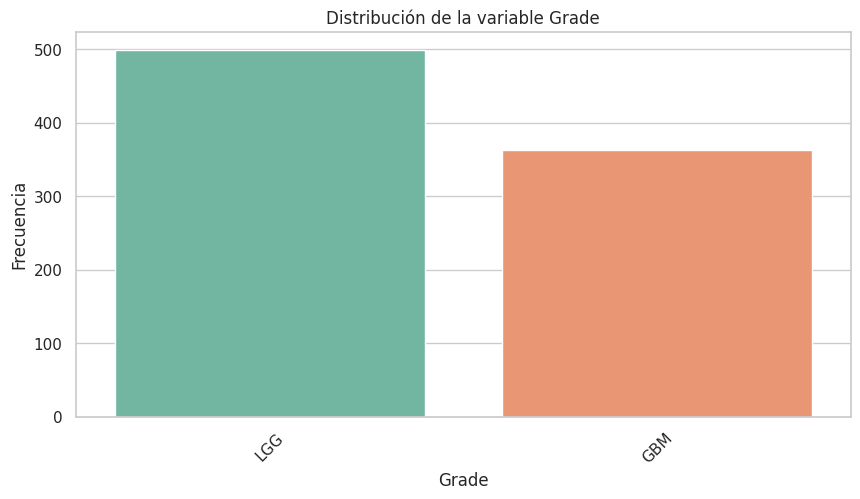

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


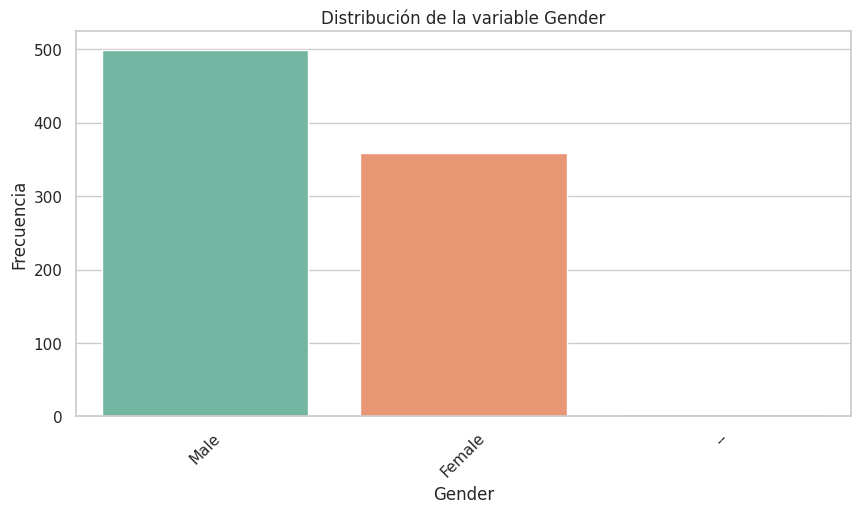

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


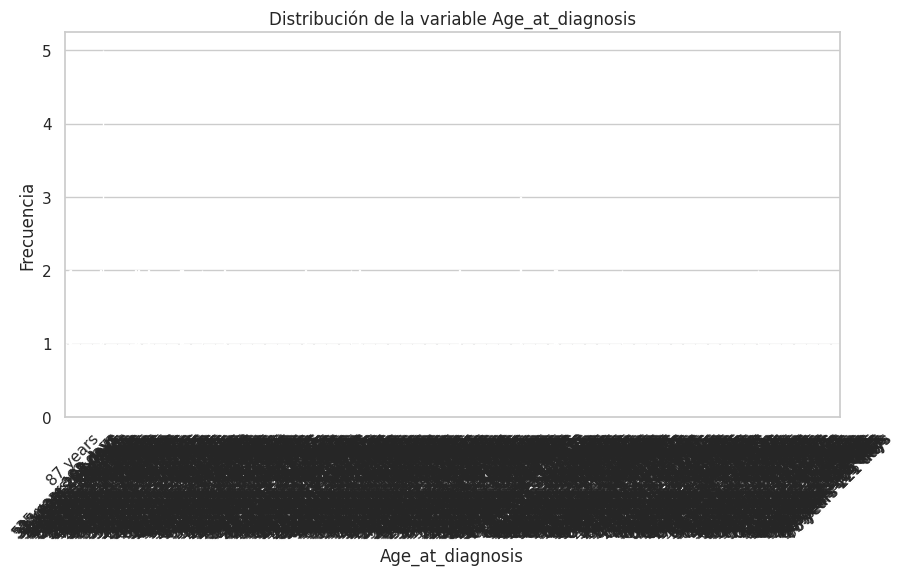

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


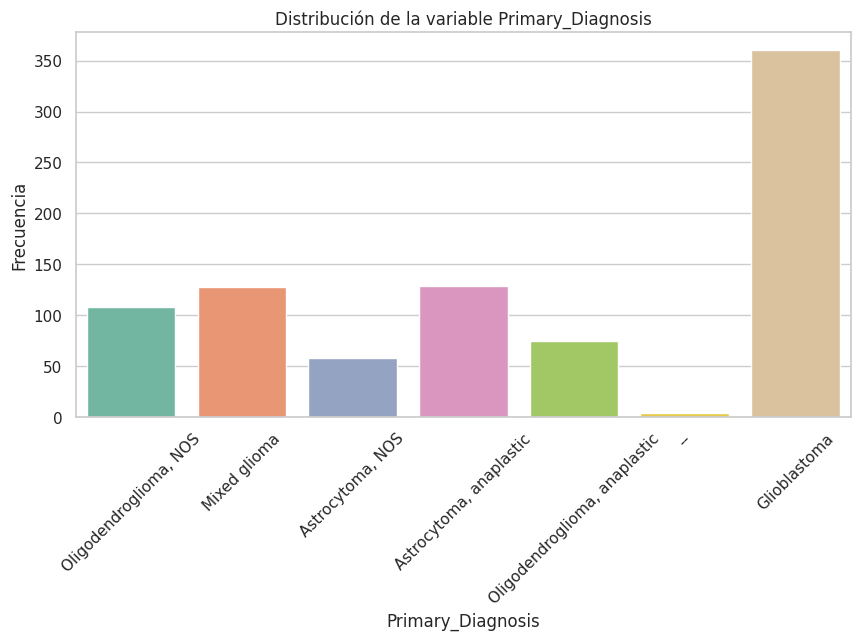

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


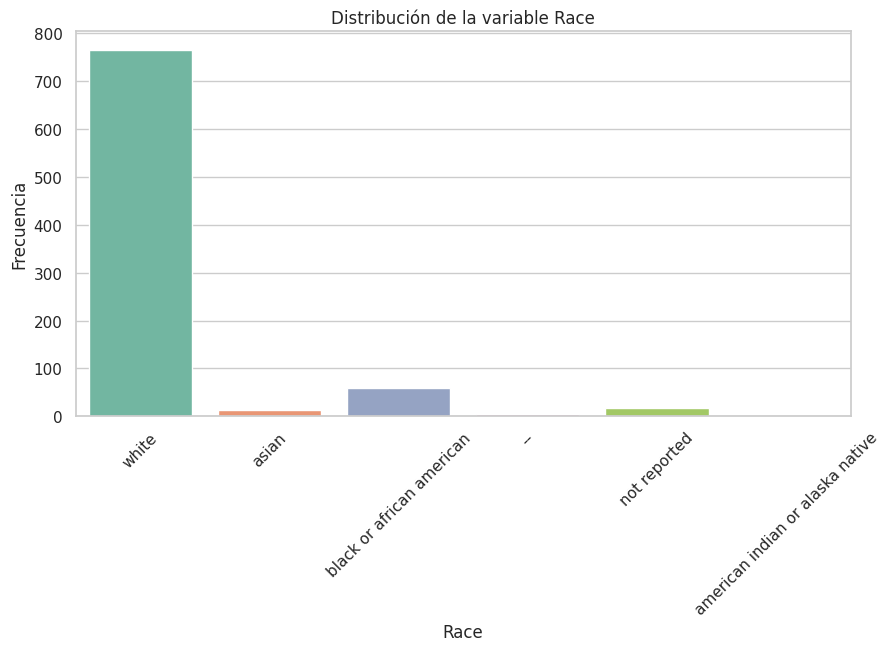

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


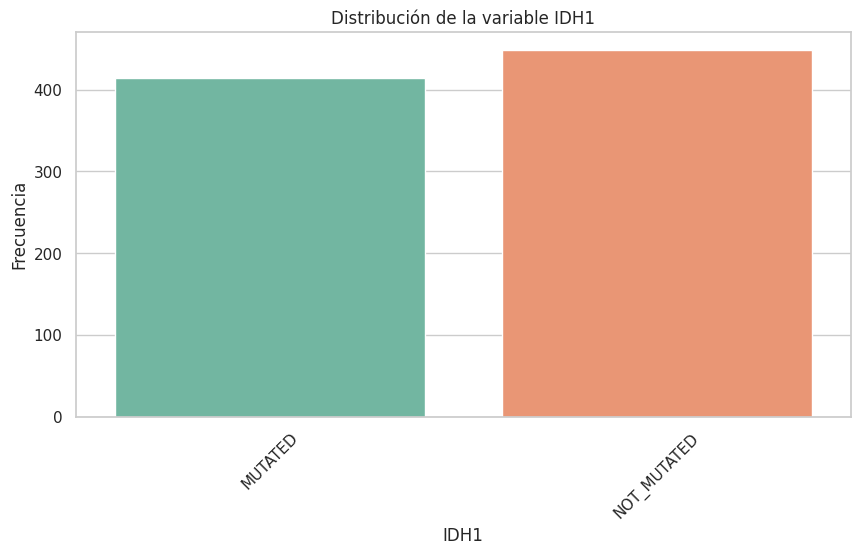

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


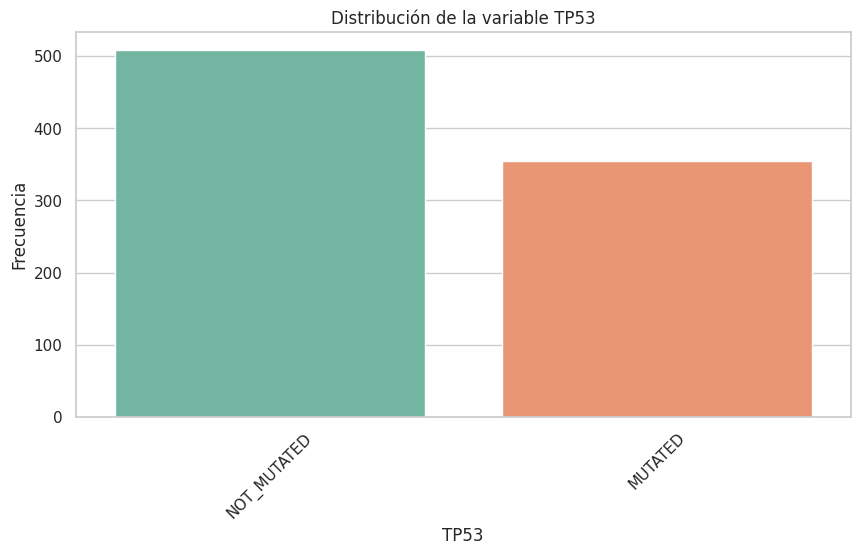

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


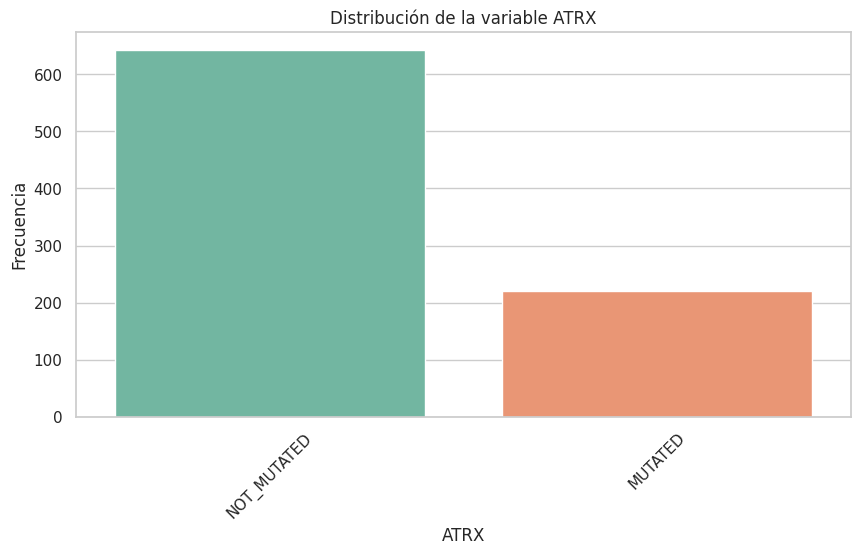

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


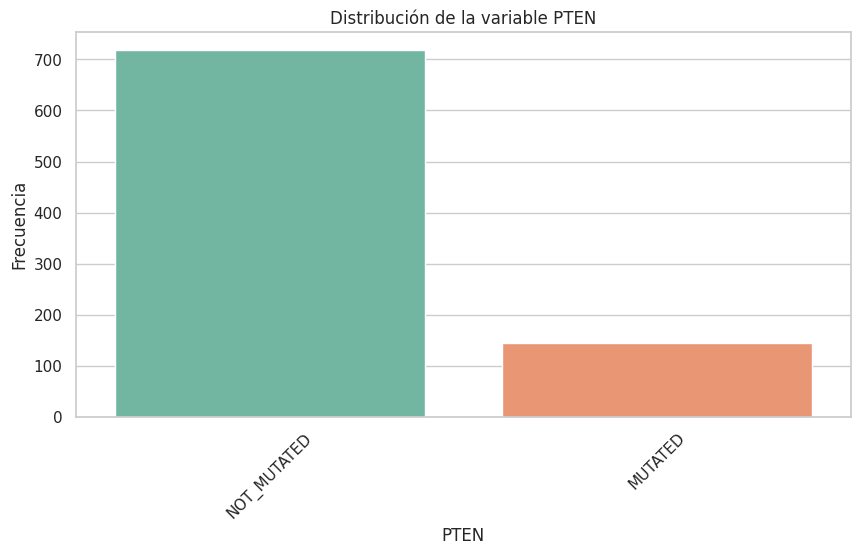

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


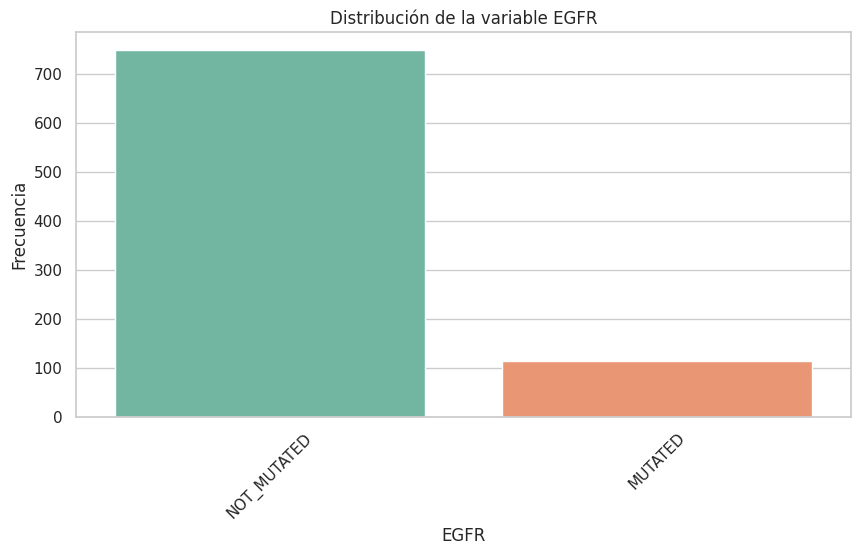

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


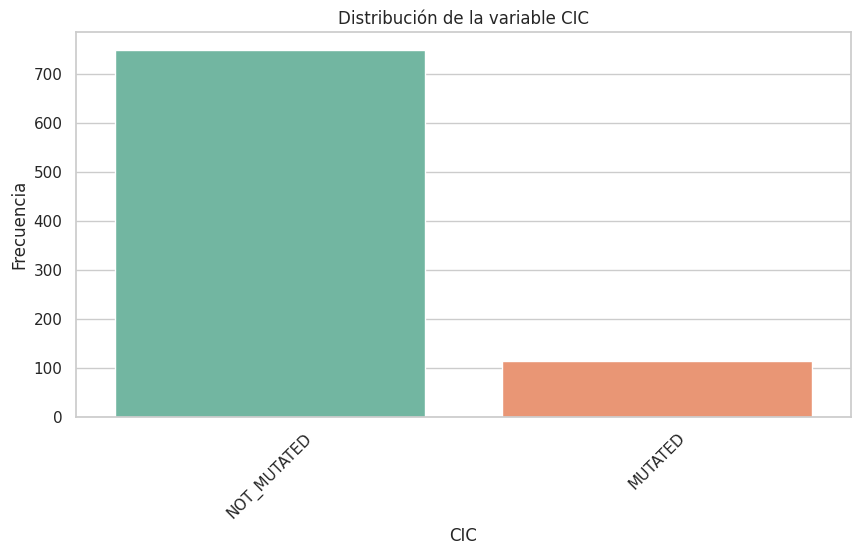

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


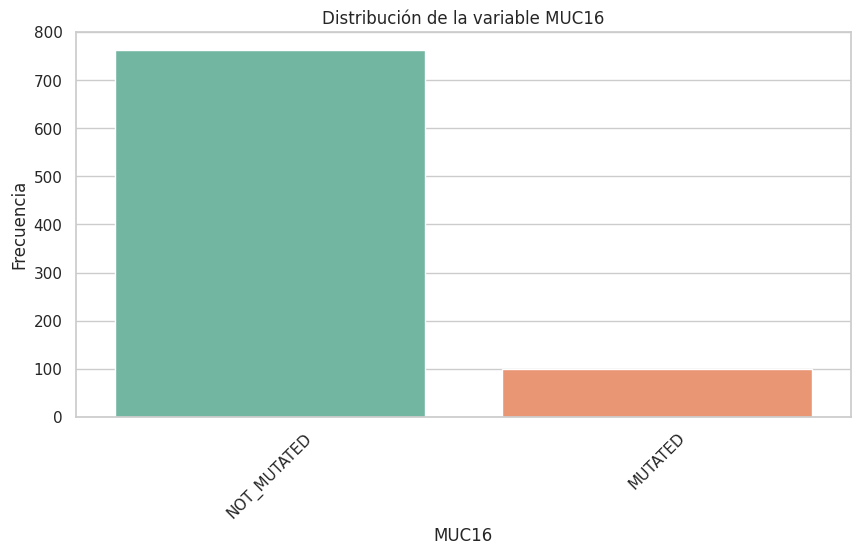

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


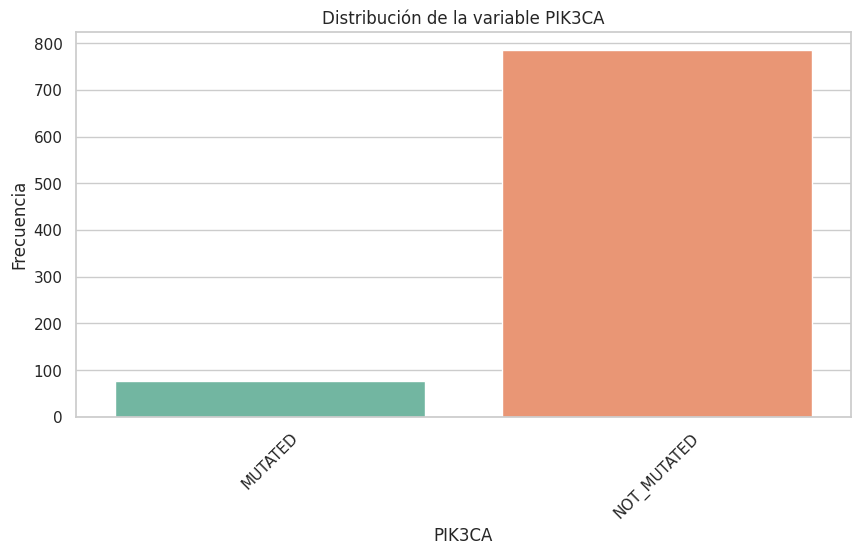

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


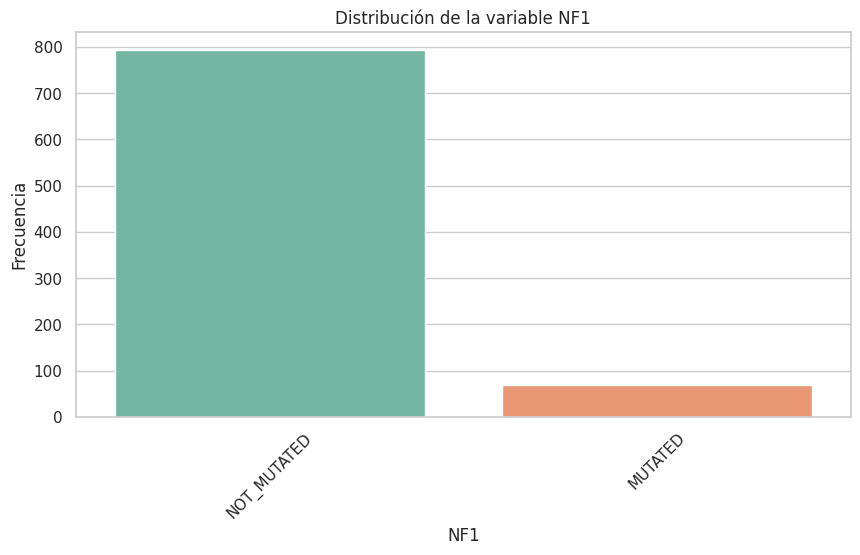

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


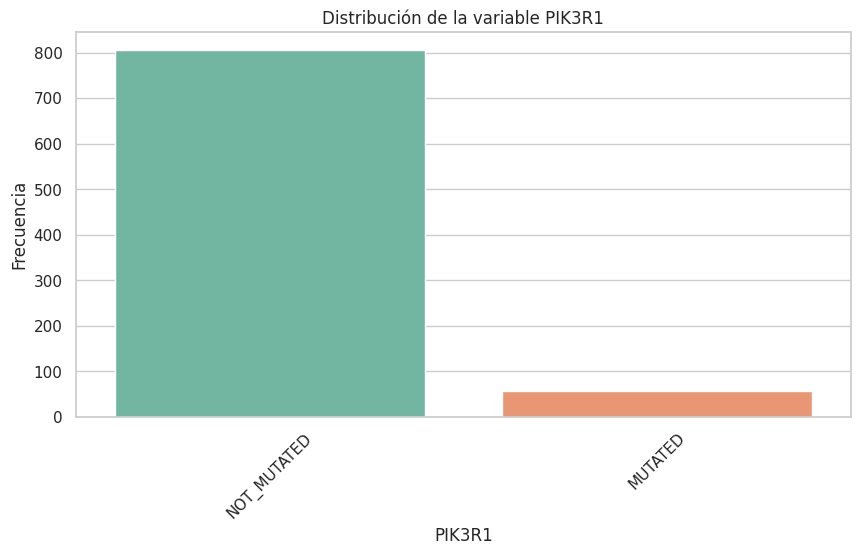

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


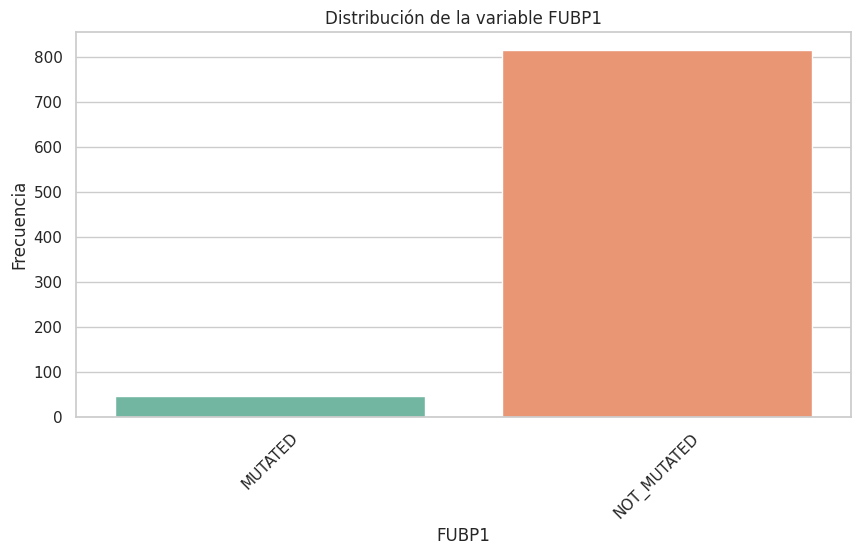

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


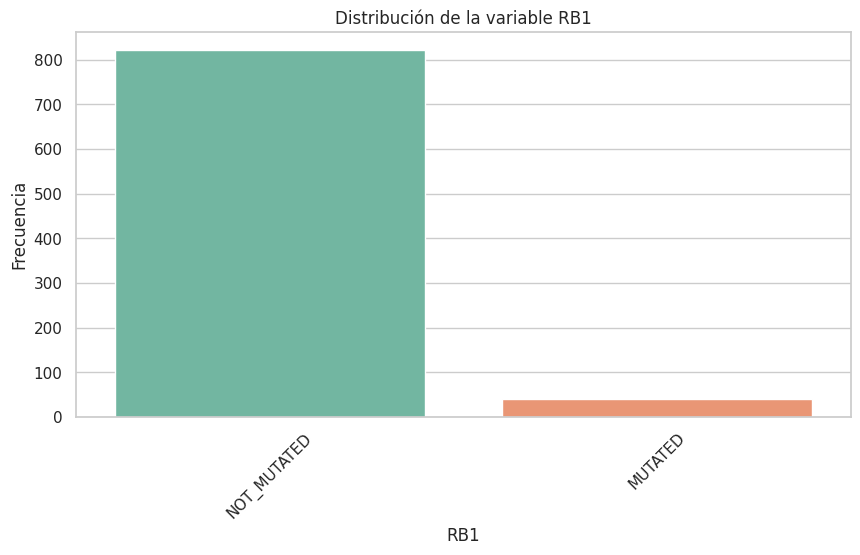

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


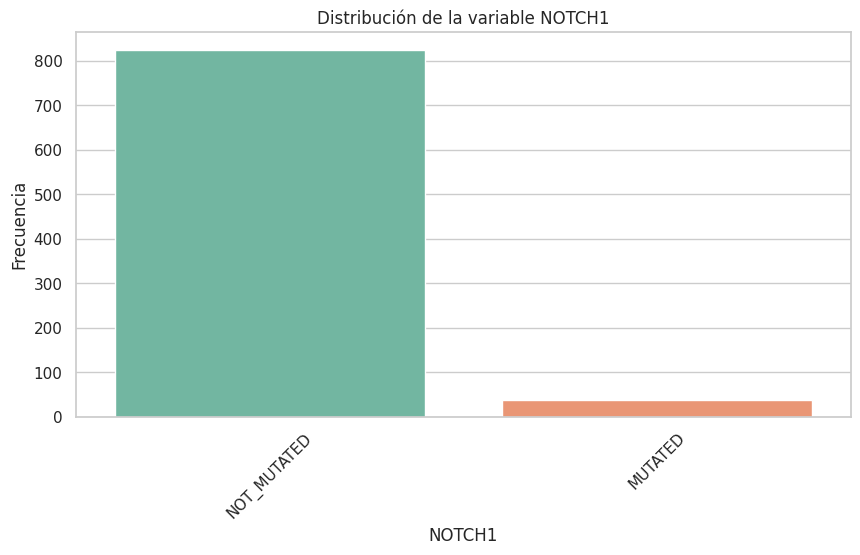

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


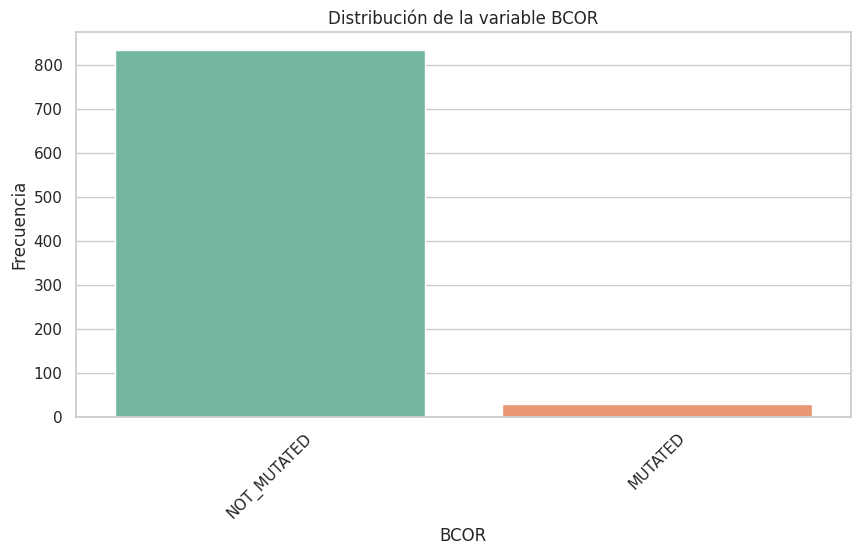

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


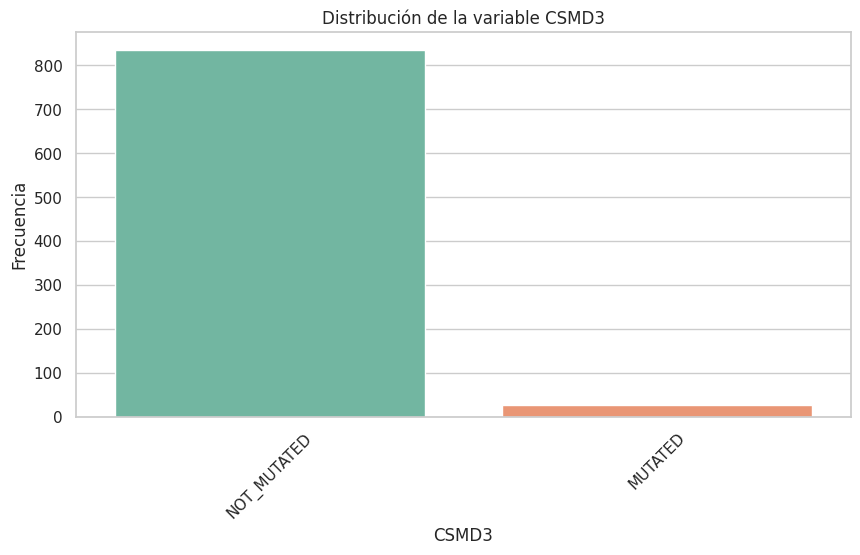

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


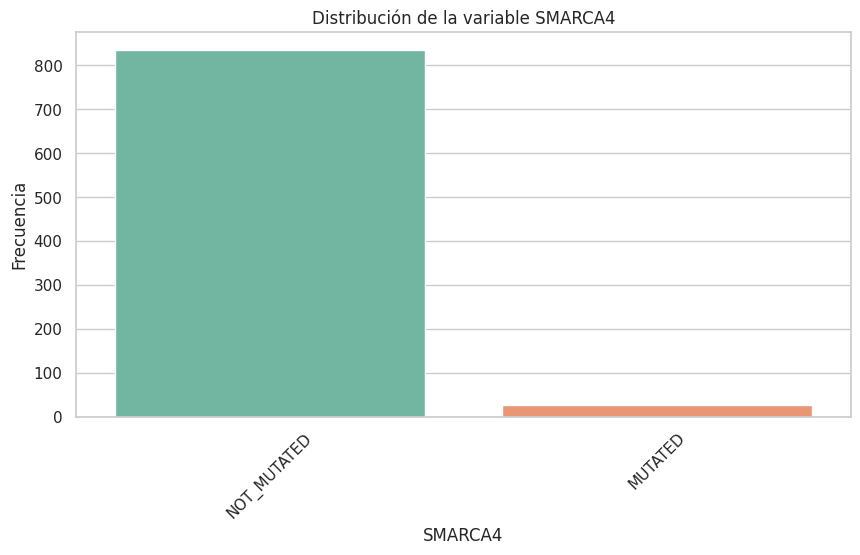

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


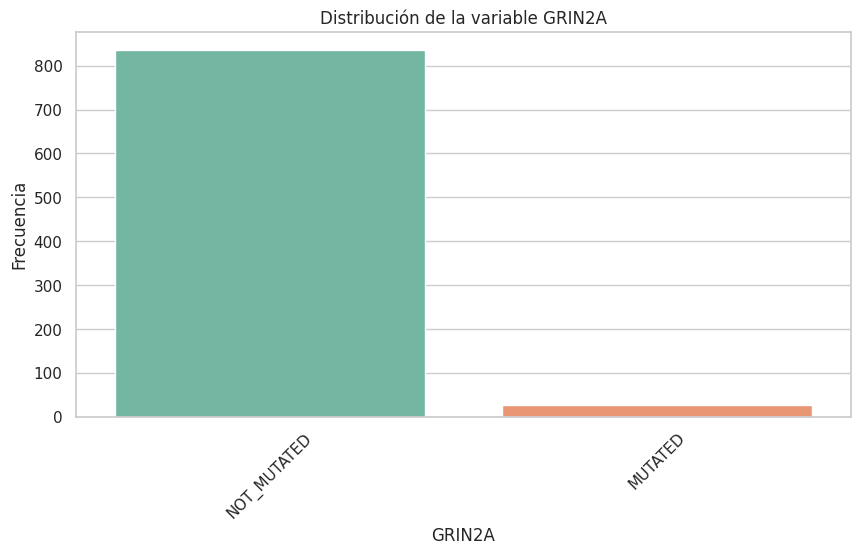

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


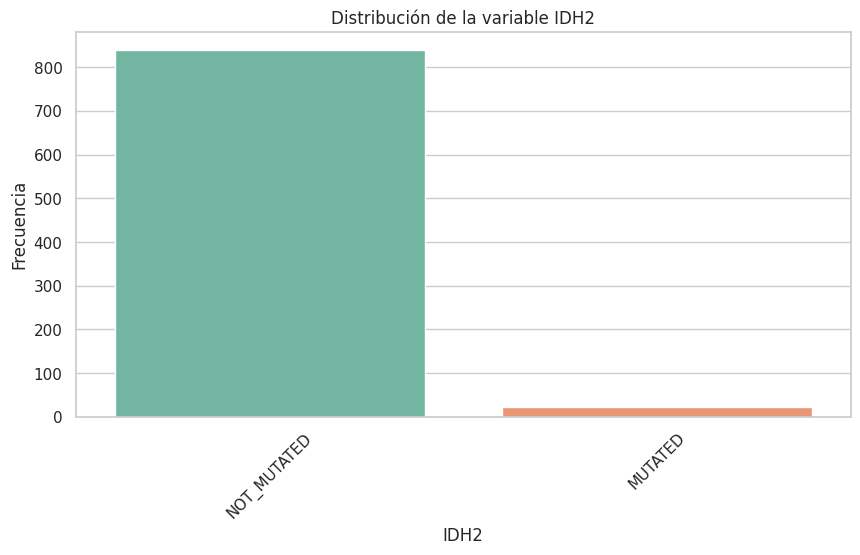

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


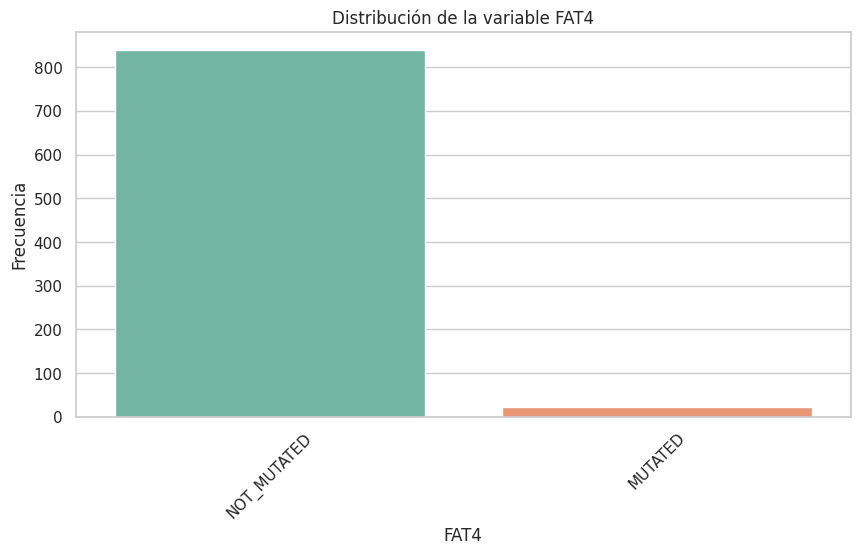

<ipython-input-14-06acb2215400>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


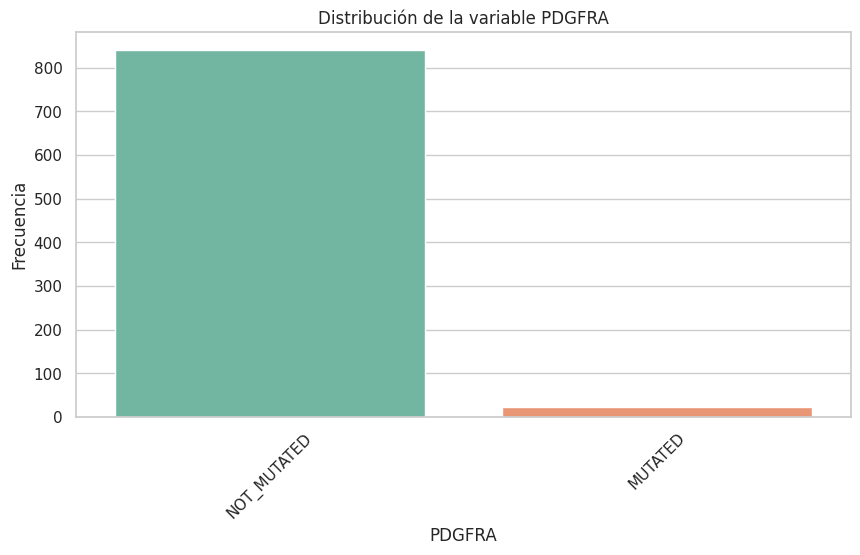

In [ ]:

# Selecciona solo las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Configura el estilo visual de los gráficos
sns.set(style="whitegrid")

# Crea un gráfico de barras para cada variable categórica
for col in categorical_cols:
    plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
    chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras
    plt.title(f'Distribución de la variable {col}')
    plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mejorar la legibilidad
    plt.xlabel(col)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y

    # Mejora en la visualización de las etiquetas si son muchas
    for item in chart.get_xticklabels():
        item.set_rotation(45)  # Rota cada etiqueta para evitar superposición

    plt.show()



A continuación, determinamos cual es la característica principal de nuestro estudio y por lo tanto la variable que nos interesa predecir.
En este caso la varible objetivo es "Primary_Diagnosis", pues es la que indica a que categoría de cancer pertenece el diagnóstico

Así, "Primary_Diagnosis" será predicha o más bien será explicada por el conjunto del resto de características de cada caso.

In [ ]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop('Primary_Diagnosis', axis=1)
y = df['Primary_Diagnosis']

Ahora realizamos una separación estandar(20-80) de datos de entrenamiento y datos de prueba para entrenar un modelo de predicción. Es decir, obtendremos de forma aleatoria un conjunto de entrenamiento con el 80% de los datos y reservaremos un 20% para poner a prueba el modelo.

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Comenzamos seleccionando todas las columnas en X_train que son de tipo 'object'(en este caso todas), que indican variables categóricas.

In [ ]:
# Preprocesamiento para variables categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns

Con **OneHotEncoder** convertimos variables categóricas en un formato numérico que puede ser utilizado por modelos de aprendizaje automático, creando una columna binaria para cada categoría.

**handle_unknown='ignore'** ignora categorías en los datos de prueba que no se vieron en los datos de entrenamiento.

Y con **sparse=False** hacemos que la salida sea una matriz densa, que es más fácil de manipular en Pandas.

Luego obtenemos los nombres de las nuevas columnas generadas por la codificación One-Hot para mantener un seguimiento claro de qué columnas corresponden a qué características categóricas.

In [ ]:
# Manejo de variables categóricas
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = enc.fit_transform(X_train[categorical_cols])
X_test_encoded = enc.transform(X_test[categorical_cols])

# Obtener los nombres de las nuevas columnas
encoded_feature_names = enc.get_feature_names_out(categorical_cols)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


A continuación convertimos las matrices codificadas en DataFrames de Pandas para facilitar operaciones futuras, como concatenar con otras columnas. Además, se combinan las características numéricas originales (después de eliminar las categóricas) con las nuevas características categóricas codificadas, formando el conjunto final de entrenamiento y prueba.

In [ ]:
# Convertir los datos codificados en un DataFrame
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names)

# Combinar las características codificadas con las numéricas
X_train_final = pd.concat([X_train.drop(categorical_cols, axis=1).reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test.drop(categorical_cols, axis=1).reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

Para mejorar la robustez y precisión del modelo, **RandomForestClassifier** es un modelo de ensamble que utiliza múltiples árboles de decisión.
Con **fit** entrenamos el modelo usando los datos que hemos ido procesando.

In [ ]:
# Entrenar el clasificador
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

A continuación usamos el modelo entrenado para predecir las etiquetas de los datos de prueba.
Finalmente evaluamos la precisión del modelo comparando las predicciones con las verdaderas etiquetas de prueba.

In [ ]:
# Predecir sobre el conjunto de prueba
y_pred = rf_classifier.predict(X_test_final)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador RandomForest:", accuracy)

Precisión del clasificador RandomForest: 0.6358381502890174


Por último, se selecciona una muestra aleatoria de 10 registros de X, se aplica el mismo preprocesamiento de codificación One-Hot a los nuevos datos y se realiza predicciones para los datos reservados con este fin; obteniendo finalmente los resultados del modelo.

In [ ]:
# Predecir la clase de al menos 10 clientes que no se hayan utilizado para entrenar el modelo
new_data = X.sample(10, random_state=42)
new_data_encoded = enc.transform(new_data[categorical_cols])
new_data_encoded = pd.DataFrame(new_data_encoded, columns=encoded_feature_names)
new_data_final = pd.concat([new_data.drop(categorical_cols, axis=1).reset_index(drop=True), new_data_encoded.reset_index(drop=True)], axis=1)

new_data_predictions = rf_classifier.predict(new_data_final)
print("Predicciones para nuevos datos:")
print(new_data)
print("Clases predichas:")
print(new_data_predictions)

Predicciones para nuevos datos:
    Grade  Gender   Age_at_diagnosis                       Race         IDH1  \
715   GBM    Male  78 years 271 days                      white  NOT_MUTATED   
605   GBM    Male  62 years 190 days                      white  NOT_MUTATED   
120   LGG  Female   37 years 83 days  black or african american      MUTATED   
208   LGG    Male  47 years 335 days               not reported      MUTATED   
380   LGG    Male   28 years 26 days                      white      MUTATED   
817   GBM  Female  66 years 320 days                      white  NOT_MUTATED   
575   GBM  Female  68 years 108 days                      white  NOT_MUTATED   
266   LGG    Male  36 years 311 days                      white      MUTATED   
557   GBM    Male  53 years 145 days                      white  NOT_MUTATED   
826   GBM    Male  79 years 183 days  black or african american  NOT_MUTATED   

            TP53         ATRX         PTEN         EGFR          CIC  ...  \
715  NOT_M

Aunque la precisión obtenida no es especialmente alta (63.58%, y por lo tanto error de 36,42%), especialmente tratandose de un estudio en el ámbito de la medicina, debemos tener en cuenta que es un problema muy complejo y hay multiples factores que no están siendo considerados.
Por ejemplo, un posible desbalance de clases en los datos debido a que hay tipos de cancer más comunes que otros, o que algunos de los genes podrían tener un impacto mucho mayor que otros en el diagnóstico.

Aun así apreciamos que el modelo ha predicho multiples clases, lo cual es un indicador de que no esta sesgado. Además, haciendo un análisis superficial de los resultados parece que se podría obtener información relevante como los tipos de cancer más comunes en función al grupo de edad.

En definitiva, consideramos que es un modelo que cumple con lo esperado y sienta muy buenas bases para trabajar en este tipo de problematicas.